# Image Super Resolution

### Author: Slothfulwave612

## Overview:

The goal of this project is to recover a high resolution image from a low resolution input. In order to accomplish this goal, we will be deploying the super-resolution convolutional neural network (SRCNN) using Keras. This network was published in the paper, **Image Super-Resolution Using Deep Convolutional Networks** by *Chao Dong, et al. in 2014*.

The research paper is attached in the GitHub Repository itself.

Single image super-resolution, which aims at
recovering a high-resolution image from a single low resolution image, is a classical problem in computer
vision, and the researchers named the proposed model Super-Resolution Convolutional Neural Network. (SRCNN)

The SRCNN is a deep convolutional neural network that learns end-toend mapping of resolution to high resolution images. As a result, we can use it to improve the image quality of low resolution images.

In here, we present a fully convolutional neural network for image super-resolution. The network directly learns an end-to-end mapping between low and high-resolution images, with little pre/postprocessing beyond the optimization.

To evaluate the performance of this network, we will be using three image quality metrics:

1. **Peak Signal-To-Noise Ratio(PSNR)**:- It is an expression for the ratio between the maximum possible value (power) of a signal and the power of distorting noise that affects the quality of its representation. The higher the PSNR, the better degraded image has been reconstructed to match the original image.

2. **Mean Squared Error(MSE)**:- It measures the average of the squares of the errors— i.e., the average squared difference between the estimated values and the actual value. For our practical purposes, it allows us to compare the “true” pixel values of our original image to our degraded image and tells the amount by which the values of the original image differ from the degraded image.

3. **Structural Similarity Index(SSIM)**:- The Structural SIMilarity (SSIM) index is a method for measuring the similarity between two images. The SSIM index can be viewed as a quality measure of one of the images being compared, provided the other image is regarded as of perfect quality.

Furthermore, we will be using **OpenCV** for *pre* and *post process* our images.

### 1. Importing Packages:

Here we are importing the pakages that we will be using for our project and will list out the version for each one of them.

Mainly we are using these following packages:

1. **sys** -- provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.

2. **keras** -- is an open-source neural-network library written in Python.

3. **cv2** -- is a library of programming functions mainly aimed at real-time computer vision.

4. **numpy** -- numerical computation library.

5. **matplotlib** -- visualization library.

6. **skimage** -- for image processing.

In [5]:
## Listing out versions for each modules 
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage

## modules versions
print('Python: {}'.format(sys.version))
print('Keras: {}'.format(keras.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Numpy: {}'.format(numpy.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Skimage: {}'.format(skimage.__version__))

Using Theano backend.


Python: 3.5.5 |Anaconda, Inc.| (default, Apr  7 2018, 04:52:34) [MSC v.1900 64 bit (AMD64)]
Keras: 2.2.4
OpenCV: 3.4.1
Numpy: 1.14.3
Matplotlib: 3.0.0
Skimage: 0.14.0


In [6]:
## import necessary packages
from keras.models import Sequential
from keras.layers import Conv2D, Input
from keras.optimizers import SGD, Adam
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
import math
import os

## python magic function
%matplotlib inline

### 2. Image Quality Metrics:

Here we will define our image quality metrics. We are going to make user-defined functions for PSNR ans MSE, the SSIM was imported directly from the scikit-image library. Furthermore, we will wrap all these metrics into a single function.

<img src="py_code_images/psnr.JPG">

<img src="py_code_images/MSE.JPG">

In [7]:
## function for peak signal-to-noise ratio (PSNR)
def psnr(target, ref):
    '''
    Function to calculate the Peak Signal-to-Noise Ratio(PSNR) 
    index for given images.
    
    Arguments:
    target -- numpy array, low resolution image.
    ref -- numpy array, high resolution image.
    
    Returns:
    float, score calculated using peak signal-to-noise ratio formula.
    '''
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten(order='C')
    
    ## root mean squared error
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255. / rmse)      ## peak signal-to-noise ratio 

## function for mean squared error(MSE)
def mse(target, ref):
    '''
    Function to calculate mean squared error.
    
    Arguments:
    target -- numpy array, target image.
    ref -- numpy array, reference image.
    
    Returns:
    float, mean squared error value
    '''
    err = np.sum( (target.astype(float) - ref.astype(float)) ** 2 )
    err /= float(target.shape[0] * target.shape[1])
    
    return err

## function for combining all three metrics
def compare_images(target, ref):
    '''
    Function that combines all three image quality metrics.
    Metrics:-   1. Peak Signal-to-Noise Ratio (PSNR)
                2. Mean Squared Error (MSE)
                3. Structural Similarity Index (SSIM)
                
    Arguments:
    target -- numpy array, a target image.
    ref -- numpy array, a reference image.
    
    Returns:
    scores -- list, containing the values for the three metrics.
    '''
    scores = []
    
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))  
    
    return scores

### 3. Preparing Images

For this project we will be using the same images that were used in the original SRCNN paper. All the images are under the source directory.

Now we will produce low resolution versions of these same images and we will place all the low resolution images in Images directory. 

We will accomplish the task for lowering down the resolution by resizing the images, both downwardsa and upwards, using OpenCV and will be using bilinear interpolation.

**Interpolation**:- Interpolation is the insertion of something of a different nature into something else.

**Bilinear Interpolation**:- A weighted average of the attributes (color, alpha, etc.) of the four surrounding pixels is computed and applied to the screen pixel. This process is repeated for each pixel forming the object being textured.

In [8]:
def prepare_images(path, factor):
    '''
    Function to prepare degraded images by introducing distortions via resizing
    
    Arguments:
    path -- file path where the high-res images are stored.
    factor -- value by which resizing will take place.
    '''
    ## looping through the files in the directory
    for file in os.listdir(path):
        ## open the image
        img = cv2.imread(path + '/' + file)
        
        ## image dimention
        h, w, c = img.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        ## resizing the image - down
        img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        ## resizing the image - up
        img = cv2.resize(img, (w, h), interpolation=cv2.INTER_LINEAR)
        
        ## save the image
        cv2.imwrite('Images/{}'.format(file), img)
        print('Saving {}'.format(file))

In [9]:
## preparing the degraded images by calling the function
prepare_images('source', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp


### 4. Testing Low Resolution Images

To ensure that our image quality metrics are being calculated correctly and that the images were effectively degraded. we will now calculate the PSNR, MSE and SSIM between our reference images and the drgraded images that we just prepared.

In [10]:
## testing the generated images using image quality metrics
for file in os.listdir('Images'):
    ## high-res images
    target = cv2.imread('source/{}'.format(file))
    
    ## low-res images
    ref = cv2.imread('Images/{}'.format(file))
    
    ## calculate the scores
    scores = compare_images(target, ref)
    
    ## display the results
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.629277587900277

baby_GT.bmp
PSNR: 34.37180640966199
MSE: 71.28874588012695
SSIM: 0.9356987872724932

barbara.bmp
PSNR: 25.906629837568126
MSE: 500.65508535879627
SSIM: 0.8098632646406401

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.9533644866026473

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.8791344763843051

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.756950063354931

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8347335416398209

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.8008439492289884

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.8697286286974628

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.933268417388899

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.8011121330733371

lenna.bmp
PSNR: 31.47349297867539
MSE: 138.948005676

### 5. Building the SRCNN Model

Now that we have our low resolution images and all three image quailty metrics are working properly. Now we will start building the SRCNN model. 

In [11]:
## defining SRCNN model
def model():
    '''
    Function defines the SRCNN model.
    
    Returns: the model itself.
    '''
    ## a sequential model
    SRCNN = Sequential()
    
    ## adding layers
    SRCNN.add(Conv2D(filters=128, kernel_size=(9,9), kernel_initializer='glorot_uniform',
                    activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='glorot_uniform',
                    activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters=1, kernel_size=(5,5), kernel_initializer='glorot_uniform',
                    activation='linear', padding='valid', use_bias=True))
    
    ## define optimizer
    adam = Adam(lr=0.0003)
    
    ## compiling model
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

### 6. Deploying the SRCNN

Before deploying the SRCNN model we need to define a couple of image processing functions. Furthermore, it will be necessary to preprocess the images before using them as input. The processing will include cropping and color space conversions.

Additionally, to save us the time it takes to train a deep neural network, we will be loading pre-trained weights for the SRCNN. These weights are in the file named as *3051crop_weight_200.h5*.

Then we will use our model for single-image super-resolution. Once we have tested our network, we can perform single-image super-resolution on all of our input images. We will calculate the PSNR, MSE and SSIM on the images that we produce. We will then save these images in an output directory displaying the original image, the degraded image and the recreated image side by side.

In [12]:
## define necessary image processing function
def modcrop(img, scale):
    '''
    Function to resize the image.
    
    Arguments:
    img -- array, the image.
    scale -- int, the scaling value.
    
    Returns:
    img -- array, the scaled image.
    '''
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0: sz[0], 1: sz[1]]
    return img

def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [31]:
# define main prediction function

def predict(image_path):
    '''
    Function to reconstruct the image.
    
    Argument:
    image_path -- str, the path of the image.
    
    Returns:
    the original, degraded and reconstructed image and the scores.
    '''
    # load the srcnn model with weights
    srcnn = model()
    srcnn.load_weights('3051crop_weight_200.h5')
    
    # load the degraded and reference images
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('source/{}'.format(file))
    
    # preprocess the image with modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convert the image to YCrCb - (srcnn trained on Y channel)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # create image slice and normalize  
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # perform super-resolution with srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process output
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copy Y channel back to image and convert to BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # remove border from reference and degraged image
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # image quality calculations
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # return images and scores
    return ref, degraded, output, scores

Degraded Image: 
PSNR: 27.248686459559124
MSE: 367.56400047398984
SSIM: 0.8690622024599293

Reconstructed Image: 
PSNR: 29.667536464964765
MSE: 210.59495793340443
SSIM: 0.8990432042366839



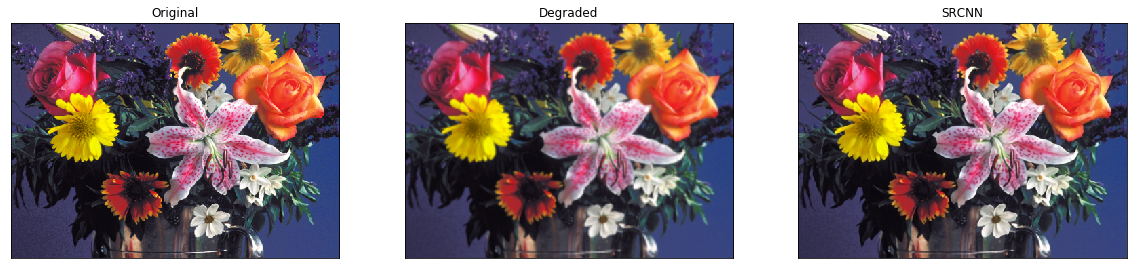

In [32]:
ref, degraded, output, scores = predict('Images/flowers.bmp')

## printing all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))

## displaying images as subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
ax[1].set_title('Degraded')
ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[2].set_title('SRCNN')

## removin the x and y ticks
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

In [33]:
## saving all reconstructed image in output file
for file in os.listdir('Images'):
    
    # perform super-resolution
    ref, degraded, output, scores = predict('Images/{}'.format(file))
    
    # display images as subplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

Saving baboon.bmp
Saving baby_GT.bmp
Saving barbara.bmp
Saving bird_GT.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving lenna.bmp
Saving monarch.bmp
Saving pepper.bmp
Saving ppt3.bmp
Saving woman_GT.bmp
Saving zebra.bmp
